
# Summary
1. Create frequency features based on selected time window to calculate the number of play/download/search behaviors within each time range. Here I use last 3,7,14,21,30 days to track the user activities.
2. Recency features show the time interval since last play/download/search date. 
3. Define generic function to create the same type of feature for different log files to process in scale.
4. For play log, apart from the frequency and recency features, I also created average play time per day within each time window. This can be an important numeric measure to track users' engagement over time.
5. Something to note: download and search log files both show unusually high traffic on 03/30. I choose to include that day because otherwise some uids will be excluded.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from pyspark.sql import SparkSession

from pyspark.sql import Row
from pyspark.sql import functions

from pyspark.sql.functions import *
from pyspark.sql.types import *


In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [3]:
spark = SparkSession.builder.appName("Music Box feature generation").getOrCreate()

## 1. Play log file feature engineering

In [13]:
play_df=spark.read.csv('./data/play_uid_label_1monthWindow/play_uid_label_1monthWindow.csv',header=True, inferSchema=True)

In [5]:
play_df.show()

+-----------+------+---------+---------+-----------+-------------------+-----+
|        uid|device|  song_id|play_time|song_length|               date|Churn|
+-----------+------+---------+---------+-----------+-------------------+-----+
|1.3586118E7|    ar| 157799.0|     31.0|      258.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar|9561562.0|      6.0|      253.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar| 237843.0|      4.0|      210.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar|9561562.0|      0.0|      253.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar|9561562.0|      4.0|      253.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar| 157671.0|      0.0|      203.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar| 157719.0|    237.0|      237.0|2017-03-30 00:00:00|    1|
|1.3586118E7|    ar| 237843.0|    210.0|      210.0|

In [6]:
play_df.printSchema()

root
 |-- uid: double (nullable = true)
 |-- device: string (nullable = true)
 |-- song_id: double (nullable = true)
 |-- play_time: double (nullable = true)
 |-- song_length: double (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- Churn: integer (nullable = true)



In [14]:
play_df=play_df.withColumn('date2', play_df.date.cast(DateType()))

In [15]:
play_df2=play_df.drop('date').withColumnRenamed("date2", "date")

In [17]:
play_df2.show()

+-----------+------+---------+---------+-----------+-----+----------+
|        uid|device|  song_id|play_time|song_length|Churn|      date|
+-----------+------+---------+---------+-----------+-----+----------+
|1.3586118E7|    ar| 157799.0|     31.0|      258.0|    1|2017-03-30|
|1.3586118E7|    ar|9561562.0|      6.0|      253.0|    1|2017-03-30|
|1.3586118E7|    ar| 237843.0|      4.0|      210.0|    1|2017-03-30|
|1.3586118E7|    ar|9561562.0|      0.0|      253.0|    1|2017-03-30|
|1.3586118E7|    ar|9561562.0|      4.0|      253.0|    1|2017-03-30|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0|    1|2017-03-30|
|1.3586118E7|    ar| 157671.0|      0.0|      203.0|    1|2017-03-30|
|1.3586118E7|    ar| 157671.0|      1.0|      203.0|    1|2017-03-30|
|1.3586118E7|    ar| 157719.0|    237.0|      237.0|    1|2017-03-30|
|1.3586118E7|    ar| 237843.0|    210.0|      210.0|    1|2017-03-30|
|1.3586118E7|    ar|9561562.0|     44.0|      253.0|    1|2017-03-30|
|1.3586118E7|    ar|

### Check the date and label distribution 

In [18]:
date_count=play_df2.groupBy('date').count().toPandas()
churn_count=play_df2.groupBy('Churn').count().toPandas()

In [32]:
date_count=date_count.sort_values(by='date')
date_count.head()

,date,count
13,2017-03-30,3942817
19,2017-03-31,5450185
27,2017-04-01,4340928
4,2017-04-02,3930786
2,2017-04-03,2240635


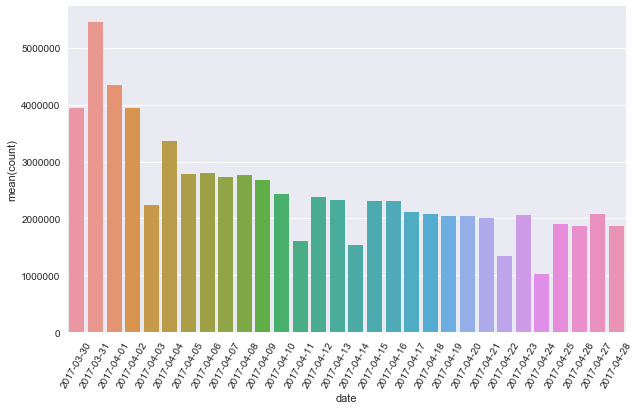

In [33]:
%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,6))
date_bar=sns.barplot(date_count['date'],date_count['count'])
loc, labels = plt.xticks()
date_bar.set_xticklabels(labels, rotation=60)

* In the play log preprocessing step, user behavior observing window is defined as between 2017-03-30 and 2017-04-28 (30 days) and churn label is assigned to inactive users during 2017-04-29 to 2017-05-12 (14 days), which is the churn prediction window.
* play file date range is in the observing window we want. distribution looks ok.

[<matplotlib.text.Text at 0x123240f60>, <matplotlib.text.Text at 0x12310c208>]

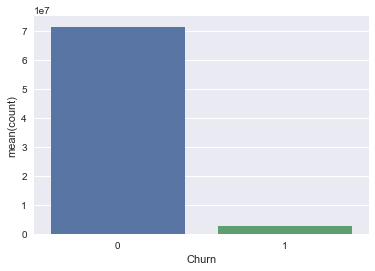

In [34]:
churn_bar=sns.barplot(churn_count['Churn'],churn_count['count'])
loc, labels = plt.xticks()
date_bar.set_xticklabels(labels)

* active user number is about 7.5 times churned user number

## My approach to feature generation for play log:
1. Measure frequency: Count the number of play times within several time window options (eg. last 3,7,14,21,30 days)
2. Measure average daily play time users spent: Get the avg play time per day within these time windows (last 3,7,14,21,30 days)
3. Measure recency: Days since last play activity

### 1. create features based on frequency

In [54]:
#test
import datetime as dt
from dateutil import parser
import pyspark.sql.functions as fn

time_window = 3
snapshot_date=parser.parse('2017-04-29').date()

play_df_3d=play_df2.filter((snapshot_date - dt.timedelta(time_window)) <= fn.col('date') )
play_3d_frq = play_df_3d.groupBy('uid').count()#.alias('frequency_play_last_3_days')

In [55]:
play_3d_frq.show()

+------------+-----+
|         uid|count|
+------------+-----+
|1.67920832E8|    9|
| 5.7077508E7|  216|
|1.68013072E8|   28|
|1.68155632E8|   13|
|1.68353024E8|   73|
|1.67884064E8|    6|
|1.68400736E8|    3|
|1.67862064E8|    8|
|1.67883424E8|  331|
|  1.682296E8|   89|
|1.68259984E8|  383|
| 1.6837208E8|   71|
| 1.6886896E8|    1|
|1.68516256E8|    6|
|1.67653728E8|   31|
|1.68935664E8|    8|
|1.69180896E8|   19|
|1.68003744E8|  130|
|1.68577056E8|   25|
|1.67712144E8|    3|
+------------+-----+
only showing top 20 rows



### > create a generic function to process frequency features for all time windows at once

In [25]:
def frequency_features_generation(df, time_window, snapshot_date, log_type):
    #column_names=[log_type+'_times_last_'+str(i)+'_days' for i in time_window]
    #same as case when in sql. sum(case when uid shows up in time window then 1 else 0)
    df_feature=df.groupBy('uid')\
                 .agg(*[fn.sum(fn.when(snapshot_date - dt.timedelta(day) <= fn.col('date'),1).otherwise(0))\
                        .alias(log_type+'_times_last_'+str(day)+'_days')\
                        for day in time_window ])
    return df_feature            

In [65]:
temp=spark.createDataFrame(play_df2.take(10))

In [80]:
try_one=frequency_features_generation(temp,[30,21],snapshot_date,'play')
try_one.show()
## looks good

+-----------+-----------------------+-----------------------+
|        uid|play_times_last_30_days|play_times_last_21_days|
+-----------+-----------------------+-----------------------+
|1.3586118E7|                     10|                      0|
+-----------+-----------------------+-----------------------+



In [82]:
time_window=[3,7,14,21,30]
play_features=frequency_features_generation(play_df2,time_window,snapshot_date,'play').cache()

In [83]:
pd.DataFrame(play_features.take(30),columns=play_features.columns)

,uid,play_times_last_3_days,play_times_last_7_days,play_times_last_14_days,play_times_last_21_days,play_times_last_30_days
0,114363528.0,0,0,0,1,20
1,167920832.0,9,22,354,560,817
2,168573152.0,0,0,0,0,109
3,57077508.0,216,372,1020,1510,2388
4,157815664.0,0,81,182,184,233
5,159183408.0,0,1,77,223,707
6,168013072.0,28,28,37,72,174
7,168155632.0,13,42,85,207,399
8,168353024.0,73,114,1921,2262,2876
9,167614368.0,0,0,0,0,70


### > create a generic function to calculate total/average play time for all time windows at once

In [97]:
def avg_playtime_perday_generation(df, time_window, snapshot_date, log_type):
    df_feature=df.groupBy('uid')\
                 .agg(*[(fn.sum(fn.when(snapshot_date - dt.timedelta(day) <= fn.col('date'),fn.col('play_time'))\
                                .otherwise(0))/day).alias('avg_playtime_last_'+str(day)+'_days')\
                        for day in time_window ])
    return df_feature  

In [103]:
try_one=avg_playtime_perday_generation(temp,[30,21],snapshot_date,'play')
try_one.show()

+-----------+-------------------------+-------------------------+
|        uid|avg_playtime_last_30_days|avg_playtime_last_21_days|
+-----------+-------------------------+-------------------------+
|1.3586118E7|        317.1666666666667|                      0.0|
+-----------+-------------------------+-------------------------+



In [99]:
def total_playtime_generation(df, time_window, snapshot_date, log_type):
    df_feature=df.groupBy('uid')\
                 .agg(*[fn.sum(fn.when(snapshot_date - dt.timedelta(day) <= fn.col('date'),fn.col('play_time'))\
                                .otherwise(0)).alias('total_playtime_last_'+str(day)+'_days')\
                        for day in time_window ])
    return df_feature

In [102]:
temp=spark.createDataFrame(play_df2.take(100))
try_one=total_playtime_generation(temp,[30,21],snapshot_date,'play')
try_one.show()

+-----------+-------------------------+-------------------------+
|        uid|avg_playtime_last_30_days|avg_playtime_last_21_days|
+-----------+-------------------------+-------------------------+
|1.3586118E7|                   9515.0|                      0.0|
+-----------+-------------------------+-------------------------+



In [104]:
avg_playtime_features = avg_playtime_perday_generation(play_df2,time_window,snapshot_date,'play').cache()

In [105]:
pd.DataFrame(avg_playtime_features.take(20),columns=avg_playtime_features.columns)

,uid,avg_playtime_last_3_days,avg_playtime_last_7_days,avg_playtime_last_14_days,avg_playtime_last_21_days,avg_playtime_last_30_days
0,114363528.0,0.000000,0.000000,0.000000,5.000000,6.600000
1,167920832.0,517.333333,484.571429,4783.285714,5169.476190,4744.166667
2,168573152.0,0.000000,0.000000,0.000000,0.000000,518.933333
3,57077508.0,8823.000000,7222.714286,9382.285714,9921.809524,10675.066667
4,157815664.0,0.000000,2289.000000,2337.071429,1562.619048,1225.666667
5,159183408.0,0.000000,17.714286,722.928571,1201.428571,2667.366667
6,168013072.0,1624.333333,696.142857,475.071429,455.571429,750.800000
7,168155632.0,554.666667,1023.428571,1044.857143,1482.285714,1817.333333
8,168353024.0,1418.333333,1761.714286,3723.642857,4903.333333,6629.900000
9,167614368.0,0.000000,0.000000,0.000000,0.000000,278.733333


### > create recency features - how many days in between the last play date and the snapshot date?
> this can tell us how long this user has been inactive. it can be an indicative feature for churn prediction

In [29]:
def recency_features_generation(df,log_type):
    
    df.createOrReplaceTempView('temp_df')
    date_diff=spark.sql("select uid,  datediff('2017-04-29', max_date) as days_since_last from \
                            (select uid, max(date) max_date from temp_df group by uid)")
    date_diff=date_diff.withColumnRenamed('days_since_last','days_since_last_'+log_type)
    return date_diff            

In [184]:
#test
d=recency_features_generation(temp,'play')
d.show()

+-----------+--------------------+
|        uid|days_since_last_play|
+-----------+--------------------+
|1.3586118E7|                  28|
+-----------+--------------------+



In [187]:
#process play_df
recency_features=recency_features_generation(play_df2 , 'play').cache()

In [188]:
pd.DataFrame(recency_features.take(10),columns=recency_features.columns)

,uid,days_since_last_play
0,114363528.0,20
1,167920832.0,1
2,168573152.0,25
3,57077508.0,1
4,157815664.0,4
5,159183408.0,6
6,168013072.0,2
7,168155632.0,3
8,168353024.0,1
9,167614368.0,25


In [192]:
print(avg_playtime_features.select('uid').distinct().count())
print(play_features.select('uid').distinct().count())
print(recency_features.select('uid').distinct().count())
# make sure all three feature dataframes have the same count.

105351
105351
105351


### > merge all the feature dataframes created for play log

In [189]:
all_play_features=play_features.join(avg_playtime_features, on=['uid'],how='left')\
                               .join(recency_features,on=['uid'],how='left').cache()
# adding [] to the col joined on tells pyspark to only keep one column with the same name in the final dataframe

In [193]:
pd.DataFrame(all_play_features.take(20),columns=all_play_features.columns)

,uid,play_times_last_3_days,play_times_last_7_days,play_times_last_14_days,play_times_last_21_days,play_times_last_30_days,avg_playtime_last_3_days,avg_playtime_last_7_days,avg_playtime_last_14_days,avg_playtime_last_21_days,avg_playtime_last_30_days,days_since_last_play
0,114363528.0,0,0,0,1,20,0.000000,0.000000,0.000000,5.000000,6.600000,20
1,167920832.0,9,22,354,560,817,517.333333,484.571429,4783.285714,5169.476190,4744.166667,1
2,168573152.0,0,0,0,0,109,0.000000,0.000000,0.000000,0.000000,518.933333,25
3,57077508.0,216,372,1020,1510,2388,8823.000000,7222.714286,9382.285714,9921.809524,10675.066667,1
4,157815664.0,0,81,182,184,233,0.000000,2289.000000,2337.071429,1562.619048,1225.666667,4
5,159183408.0,0,1,77,223,707,0.000000,17.714286,722.928571,1201.428571,2667.366667,6
6,168013072.0,28,28,37,72,174,1624.333333,696.142857,475.071429,455.571429,750.800000,2
7,168155632.0,13,42,85,207,399,554.666667,1023.428571,1044.857143,1482.285714,1817.333333,3
8,168353024.0,73,114,1921,2262,2876,1418.333333,1761.714286,3723.642857,4903.333333,6629.900000,1
9,167614368.0,0,0,0,0,70,0.000000,0.000000,0.000000,0.000000,278.733333,25


> Great! The combined features for play look good! Save it to a csv file.

In [194]:
all_play_features.repartition(1).write.csv('./data/all_play_features',header=True)

## 2. Download Log Feature Engineering

* With all the necessary functions defined earlier, download and search log feature generation should be very straightforward

In [195]:
down_df=spark.read.csv('./data/down_df_clean/down_df_clean.csv',header=True,inferSchema=True)

In [196]:
down_df.show() #when writing into csv file, date col always get converted to datetime format by spark automatically

+-----------+-----------+-------------------+
|        uid|    song_id|               date|
+-----------+-----------+-------------------+
|  4550267.0|  6196608.0|2017-03-31 00:00:00|
|  4550267.0|  6485492.0|2017-03-31 00:00:00|
|  4550267.0|   859133.0|2017-03-31 00:00:00|
|  6216081.0|   298180.0|2017-04-04 00:00:00|
|  6216081.0|   157526.0|2017-04-10 00:00:00|
|  6216081.0|  5040158.0|2017-04-10 00:00:00|
|  6216081.0|2.1769686E7|2017-04-13 00:00:00|
|  6216081.0|   656643.0|2017-04-13 00:00:00|
|  6216081.0|  3206899.0|2017-04-20 00:00:00|
|  6216081.0|   541474.0|2017-04-21 00:00:00|
|  6216081.0|   148209.0|2017-04-26 00:00:00|
|  6216081.0|2.1766068E7|2017-04-27 00:00:00|
|  6216081.0|  1521504.0|2017-04-30 00:00:00|
|  6869869.0|   176322.0|2017-04-13 00:00:00|
|2.2553002E7|2.0929864E7|2017-05-01 00:00:00|
|2.2553002E7|1.1416998E7|2017-05-01 00:00:00|
|2.2553002E7|  9883448.0|2017-05-01 00:00:00|
|5.7077508E7|  3432288.0|2017-04-16 00:00:00|
|5.7077508E7|  3385963.0|2017-04-1

In [197]:
down_df=down_df.withColumn('date2', down_df.date.cast(DateType())).drop('date').withColumnRenamed('date2','date')

In [198]:
down_df.show()

+-----------+-----------+----------+
|        uid|    song_id|      date|
+-----------+-----------+----------+
|  4550267.0|  6196608.0|2017-03-31|
|  4550267.0|  6485492.0|2017-03-31|
|  4550267.0|   859133.0|2017-03-31|
|  6216081.0|   298180.0|2017-04-04|
|  6216081.0|   157526.0|2017-04-10|
|  6216081.0|  5040158.0|2017-04-10|
|  6216081.0|2.1769686E7|2017-04-13|
|  6216081.0|   656643.0|2017-04-13|
|  6216081.0|  3206899.0|2017-04-20|
|  6216081.0|   541474.0|2017-04-21|
|  6216081.0|   148209.0|2017-04-26|
|  6216081.0|2.1766068E7|2017-04-27|
|  6216081.0|  1521504.0|2017-04-30|
|  6869869.0|   176322.0|2017-04-13|
|2.2553002E7|2.0929864E7|2017-05-01|
|2.2553002E7|1.1416998E7|2017-05-01|
|2.2553002E7|  9883448.0|2017-05-01|
|5.7077508E7|  3432288.0|2017-04-16|
|5.7077508E7|  3385963.0|2017-04-16|
|5.7077508E7|  6525213.0|2017-04-16|
+-----------+-----------+----------+
only showing top 20 rows



### Check the date distribution for download log

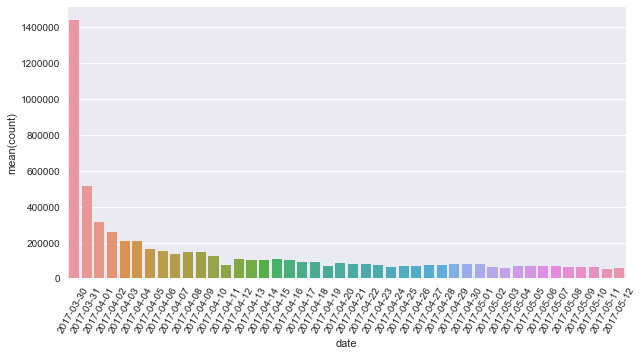

In [200]:
date_count_down=down_df.groupBy('date').count().orderBy('date').toPandas()
plt.figure(figsize=(10,5))
date_bar=sns.barplot(date_count_down['date'],date_count_down['count'])
loc, labels = plt.xticks()
date_bar.set_xticklabels(labels, rotation=60)

* 2017/03/30 has unusually high count as I found in the preprocessing step. if I exclude that day's record, some uids might have been eliminated as a result. if keeping that day, it'd drive up the frequency count in time window of 30 days only. I'll leave the records there.

In [204]:
down_df2=down_df.filter(col('date')<='2017-04-28')

### > create frequency features for download log

In [205]:
time_window=[3,7,14,21,30]
snapshot_date=parser.parse('2017-04-29').date()
down_freq_features=frequency_features_generation(down_df2,time_window,snapshot_date,'download').cache()

In [206]:
pd.DataFrame(down_freq_features.take(20),columns=down_freq_features.columns)

,uid,download_times_last_3_days,download_times_last_7_days,download_times_last_14_days,download_times_last_21_days,download_times_last_30_days
0,4550267.0,0,0,0,0,3
1,6216081.0,2,2,4,8,9
2,6869869.0,0,0,0,1,1
3,57077508.0,0,0,4,4,4
4,76332040.0,3,5,14,29,46
5,85105032.0,0,0,1,4,4
6,97017544.0,0,0,0,0,9
7,114363528.0,0,0,3,6,14
8,125593056.0,8,8,8,9,9
9,141113808.0,0,0,0,13,398


### > create recency feature for downlaod

In [207]:
down_recency_features=recency_features_generation(down_df2, 'download').cache()

### > combine frequency and recency features for download

In [208]:
all_down_features=down_freq_features.join(down_recency_features, on=['uid'],how='left').cache()

In [209]:
pd.DataFrame(all_down_features.take(10),columns=all_down_features.columns)

,uid,download_times_last_3_days,download_times_last_7_days,download_times_last_14_days,download_times_last_21_days,download_times_last_30_days,days_since_last_download
0,4550267.0,0,0,0,0,3,29
1,6216081.0,2,2,4,8,9,2
2,6869869.0,0,0,0,1,1,16
3,57077508.0,0,0,4,4,4,13
4,76332040.0,3,5,14,29,46,3
5,85105032.0,0,0,1,4,4,11
6,97017544.0,0,0,0,0,9,30
7,114363528.0,0,0,3,6,14,12
8,125593056.0,8,8,8,9,9,1
9,141113808.0,0,0,0,13,398,21


#### how is the frequency of download distribution across 5 time windows?

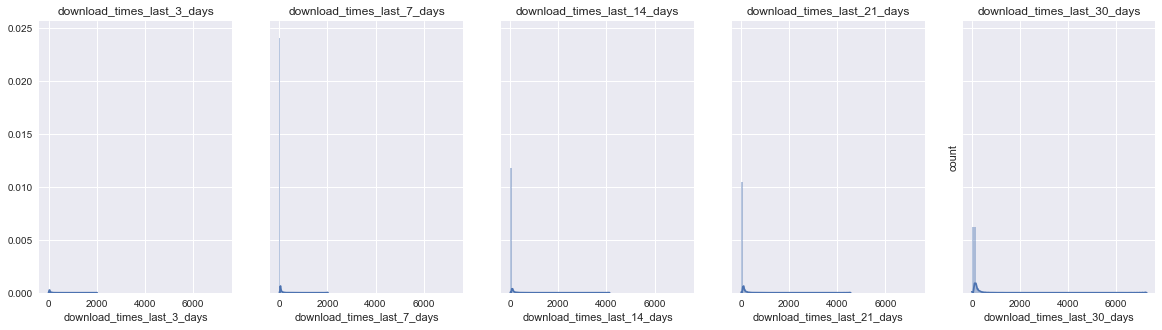

In [214]:
all_down_features_copy=all_down_features.toPandas()
f, axs = plt.subplots(1,5, sharex = True, sharey=True, figsize = (20,5))
for w in time_window:
    i = time_window.index(w)
    colname = 'download_times_last_' + str(w) + '_days'
    plt.xlabel("downlaod times")
    plt.ylabel('count')
    sns.distplot(all_down_features_copy[colname],ax = axs[i], bins = 50)

    axs[i].set_title(colname)

* can see 30 days window has a very long tail, which is expected.

In [216]:
#save the download features to csv
all_down_features.repartition(1).write.csv('./data/all_down_features',header=True)

## 3. Search Log Feature Engineering

In [16]:
search_df=spark.read.csv('./data/search_df_clean/search_df_clean.csv',header=True)

In [17]:
search_df.show()

+------------+----------+
|         uid|      date|
+------------+----------+
|1.67710496E8|2017-05-12|
|1.67710496E8|2017-05-12|
|1.68051584E8|2017-05-12|
|1.67618288E8|2017-05-12|
|    736305.0|2017-05-12|
|  1.677704E8|2017-05-12|
|1.68051456E8|2017-05-12|
|1.67949952E8|2017-05-12|
|1.67691616E8|2017-05-12|
|1.67883776E8|2017-05-12|
|1.67729312E8|2017-05-12|
|1.67623568E8|2017-05-12|
|1.67762768E8|2017-05-12|
|1.67856128E8|2017-05-12|
|1.67710496E8|2017-05-12|
|1.67979936E8|2017-05-12|
|1.68050656E8|2017-05-12|
| 3.7025504E7|2017-05-12|
|1.68036048E8|2017-05-12|
|1.37035792E8|2017-05-12|
+------------+----------+
only showing top 20 rows



### check date distribution of search log

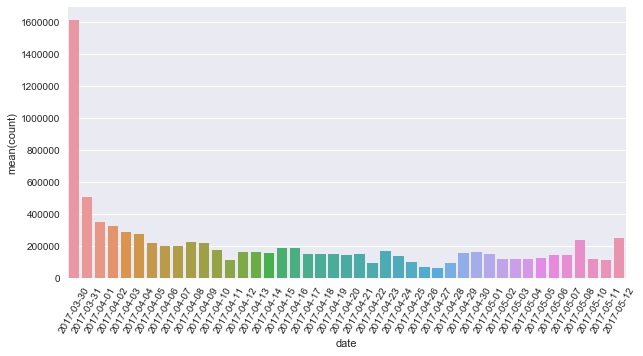

In [19]:
%matplotlib inline
import seaborn as sns
date_count_src=search_df.groupBy('date').count().orderBy('date').toPandas()
plt.figure(figsize=(10,5))
date_bar=sns.barplot(date_count_src['date'],date_count_src['count'])
loc, labels = plt.xticks()
date_bar.set_xticklabels(labels, rotation=60)

In [20]:
search_df2=search_df.filter(col('date')<='2017-04-28')

### > create frequency features for search log

In [28]:
# from dateutil import parser
# import pyspark.sql.functions as fn
# import datetime as dt

time_window=[3,7,14,21,30]
snapshot_date=parser.parse('2017-04-29').date()
search_freq_features=frequency_features_generation(search_df2,time_window,snapshot_date,'search').cache()

### > create recency feature for search log

In [30]:
search_recency_features=recency_features_generation(search_df2, 'search').cache()

### > combine frequency and recency features for search

In [31]:
all_search_features=search_freq_features.join(search_recency_features, on=['uid']).cache()

In [32]:
pd.DataFrame(all_search_features.take(20),columns=all_search_features.columns)

,uid,search_times_last_3_days,search_times_last_7_days,search_times_last_14_days,search_times_last_21_days,search_times_last_30_days,days_since_last_search
0,1.05498152E8,0,0,0,1,3,15
1,1.10170856E8,0,0,0,0,7,28
2,1.12210296E8,0,0,10,10,10,10
3,1.2296896E8,4,12,20,37,39,3
4,1.2446004E8,0,12,22,43,66,5
5,1.33297984E8,0,2,6,6,27,4
6,1.33634408E8,0,0,0,1,1,21
7,1.370176E8,8,8,8,8,8,1
8,1.39248832E8,0,0,0,0,1,30
9,1.41393792E8,0,0,0,0,1,30


In [33]:
all_search_features.repartition(1).write.csv('./data/all_search_features',header=True)

# End of feature engineering for individual log files

next step: combine all the 3 feature dataframes into one single feature table and build classification models